The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


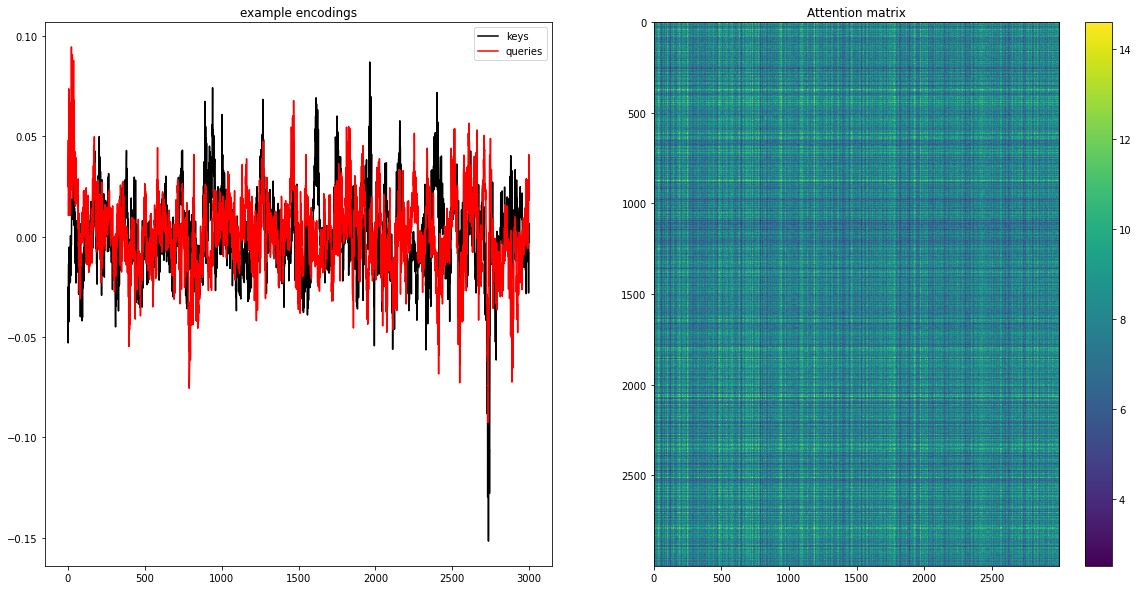

In [8]:
%load_ext autoreload
%autoreload 2

import torch
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sine or conv
conv = False

# number of layers to simulate
n_layers = 5

# dimension for the keys and queries
keys_dim = 64
spe_dim = 32
num_heads = 8
num_realizations = 32
num_sines = 10

# create the positional encoder, with a specified max lag
if conv:
    encoder = spe.ConvSPE(ndim=1, in_features=spe_dim, kernel_size=200, num_heads=num_heads, num_realizations=num_realizations)
else:
    encoder = spe.SineSPE(num_heads=num_heads, in_features=spe_dim, num_sines=num_sines, num_realizations=num_realizations)
encoder.to(device=device)

# draw keys and queries, as one for the test (activate all patterns)
n = 3000
batchsize=16


# generate some encodings of shape (batchsize, num, n)
q = torch.rand(batchsize, n, num_heads, keys_dim, device=device, requires_grad = True)
k = torch.rand(batchsize, n, num_heads, keys_dim, device=device, requires_grad = True)

from tqdm import tqdm

loss = 0
for iteration in tqdm(range(n_layers)):
    # compute the average attention matrix
    q, k = encoder(q,k)

    A = torch.mm(q[0,:,0,:], k[0,:,0,:].T)

    loss = loss + A.sum()

A = torch.mm(q[0,:,0,:].detach(), k[0,:,0,:].T.detach())
    

# display some queries and keys
q = q.detach()
k = k.detach()

plt.figure(figsize=[20,10]);
plt.subplot(121)
plt.plot(k[0,:,0,0].cpu(),'k');
plt.plot(q[0,:,0,0].cpu(),'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(122);
plt.imshow(A.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix');
plt.colorbar();


In [3]:
qhat.shape

torch.Size([16, 3000, 8, 64])

torch.Size([50, 1]) torch.Size([100, 10])


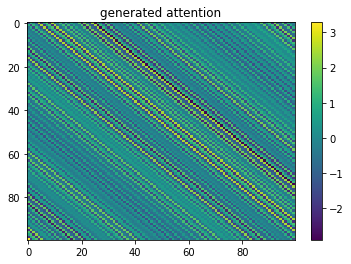

In [146]:
# IDEA: 
#generate random toeplitz matrices with a V_q D V_k^H decomposition
m = 100
n= 100
k=10
r = 128

# generate random frequencies (on the unit circle) exp(i 2 pi f ) with f in [0 1]
v = torch.randn(k, dtype=torch.cfloat, requires_grad=False); v=v/v.abs()

# rotate them according to some positions. (m, k) and (n,k)
Vq = v[None, :] ** torch.linspace(0,1000,m)[:, None]
Vk = v[None, :] ** torch.linspace(1000,2000,n)[:, None]

# draw random weights for each frequency
lamb = torch.rand(k)
#z = lamb[:, None] * torch.randn(k,r, dtype=torch.cfloat)
# compute the encodings
print(z.shape, Vq.shape)
Q= Vq * lamb[None]#Q = torch.mm(Vq,z)
K = Vk * lamb[None]#K = torch.mm(Vk, z)

"""C = torch.mm(Q, torch.conj(K.T)).real
loss = C.abs().sum()
loss.backward()
"""

plt.imshow(torch.mm(Q, torch.conj(K.T)).real.detach().cpu().numpy(), aspect='auto', interpolation='nearest')
plt.title('generated attention')
plt.colorbar()

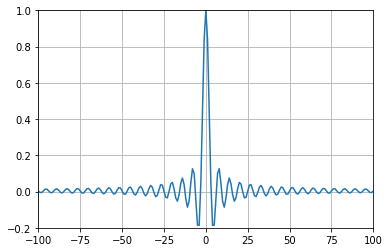

In [5]:
import numpy as np
import matplotlib.pyplot as plt

f = np.linspace(0, 1, 128)
n = np.linspace(-100, 100, 201)

cos_fn = np.sum(np.cos(f[:, None] * n[None, :]), axis=0)

plt.plot(n, cos_fn/np.max(np.abs(cos_fn)))
plt.axis([-100, 100, -0.2, 1])
plt.grid(True)
plt.xlabel('m-n')
plt.ylabel('')
plt.title('The attention pattern for APE')